In [86]:
import os
import pickle
import random

from glob import glob
from pathlib import Path
from itertools import product

import cv2
import imgaug as ia
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np

from imgaug import augmenters as iaa
from shapely.geometry import Polygon
from tqdm import tqdm

from src.background_factory import BackgroundFactory


In [73]:
DATA_DIR = "data/"
OUT_DIR = "out/"

DTD = "dtd/"
IMAGES = "images/"
BACKGROUNDS = "backgrounds/"

ANGLE_1 = "angle_1/"
ANGLE_2 = "angle_2/"

CARD_NAMES = "cardnames.txt"
BACKGROUNDS_PKL = "backgrounds.pkl"

<center> <h3> Utility Functions </h3> </center>

In [74]:
def display_img(img, polygons=[], channels="bgr", size=9):
    """
        Function to display an inline image, and draw optional polygons (bounding boxes, convex hulls) on it.
        Use the param 'channels' to specify the order of the channels ("bgr" for an image coming from OpenCV world)
    """
    if not isinstance(polygons, list):
        polygons = [polygons]
    if channels == "bgr":  # bgr (cv2 image)
        nb_channels = img.shape[2]
        if nb_channels == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=(size, size))
    ax.set_facecolor((0, 0, 0))
    ax.imshow(img)
    for polygon in polygons:
        # An polygon has either shape (n,2),
        # either (n,1,2) if it is a cv2 contour (like convex hull).
        # In the latter case, reshape in (n,2)
        if len(polygon.shape) == 3:
            polygon = polygon.reshape(-1, 2)
        patch = patches.Polygon(polygon, linewidth=1, edgecolor="g", facecolor="none")
        ax.add_patch(patch)


<center> <h3> Downloading background images </h3> </center>

In [75]:
!mkdir -p $DATA_DIR$BACKGROUNDS
!wget -O $DATA_DIR$BACKGROUNDS/backgrounds.tar.gz https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
!tar -xvf $DATA_DIR$BACKGROUNDS/backgrounds.tar.gz -C $DATA_DIR$BACKGROUNDS
!mv $DATA_DIR$BACKGROUNDS$DTD$IMAGES $DATA_DIR$BACKGROUNDS
!rm -r $DATA_DIR$BACKGROUNDS$DTD
!rm $DATA_DIR$BACKGROUNDS/backgrounds.tar.gz

--2021-12-30 18:25:19--  https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625239812 (596M) [application/x-gzip]
Saving to: ‘data/backgrounds//backgrounds.tar.gz’

data/backgrounds//b 100%[===================>] 596.27M  60.7MB/s    in 10s     

2021-12-30 18:25:31 (57.2 MB/s) - ‘data/backgrounds//backgrounds.tar.gz’ saved [625239812/625239812]

dtd/
dtd/labels/
dtd/labels/test2.txt
dtd/labels/train2.txt
dtd/labels/test7.txt
dtd/labels/train3.txt
dtd/labels/train8.txt
dtd/labels/val3.txt
dtd/labels/val8.txt
dtd/labels/train10.txt
dtd/labels/train6.txt
dtd/labels/val2.txt
dtd/labels/test1.txt
dtd/labels/val5.txt
dtd/labels/test10.txt
dtd/labels/train1.txt
dtd/labels/val4.txt
dtd/labels/labels_joint_anno.txt
dtd/labels/test3.txt
dtd/labels/train9.txt
dtd/labels/val

<cener> <h3> Process background images and pickle them </h3> </center>

In [76]:
DTD_DIR = DATA_DIR + BACKGROUNDS + IMAGES

bg_imgs = []
for subdir in os.listdir(DTD_DIR):
    for image in os.listdir(DTD_DIR + subdir):
        if not image.endswith(".jpg"):
            continue

        bg_imgs.append(DTD_DIR + subdir + "/" + image)

print("Number of background images:", len(bg_imgs))
pickle.dump(bg_imgs, open(DATA_DIR + BACKGROUNDS + BACKGROUNDS_PKL, "wb"))
print("Background images saved in", DATA_DIR + BACKGROUNDS + BACKGROUNDS_PKL)


Number of background images: 5640
Background images saved in data/backgrounds/backgrounds.pkl


In [78]:
bg_factory = BackgroundFactory()

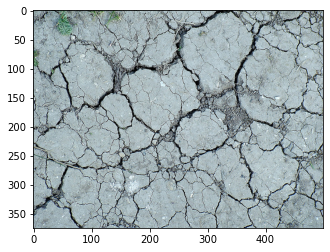

In [79]:
bg = bg_factory.get_random_background()
_ = plt.imshow(bg)

<center> <h3> Setting up the dataset </h3> </center>

In [80]:
vals = ["9", "10", "J", "Q", "K", "A"]
suits = ["C", "D", "H", "S"]

# Check if cardnames.txt exists
if not os.path.exists(os.path.join(DATA_DIR, CARD_NAMES)):
    cards = []
    for item in product(vals, suits):
        cards.append("".join(item))

    with open(DATA_DIR + CARD_NAMES, "w") as f:
        for card in cards:
            f.write(card + "\n")


In [81]:
vals_ord = ["9", "10", "J", "Q", "K", "A"]
suits_ord = ["S", "H", "C", "D"]
no_cloths = 3
angles = [ANGLE_1, ANGLE_2]

for angle in angles:
    files = os.listdir(DATA_DIR + IMAGES + angle)
    files = sorted([DATA_DIR + IMAGES + angle + f for f in files])
    no_parts = len(files) // no_cloths

    for i in range(no_cloths):
        part_files = files[0 + i * no_parts : (i + 1) * no_parts]
        cur_val = -1
        cur_suit = -1
        for ind, old_file in enumerate(part_files):
            if ind % 3 == 0:
                cur_suit += 1
                cur_suit %= 4

            if ind % 12 == 0:
                cur_val += 1
                cur_val %= 6

            new_name = f"{vals_ord[cur_val]}{suits_ord[cur_suit]}_{i}{ind % 3}.jpg"
            # Check if file already exists if not rename
            if not os.path.exists(DATA_DIR + IMAGES + angle + new_name):
                os.rename(old_file, DATA_DIR + IMAGES + angle + new_name)


In [82]:
card_suits = ["C", "D", "H", "S"]
card_values = ["9", "10", "J", "Q", "K", "A"]

# In mms
cardW = 58
cardH = 89
cornerXmin = 2.5
cornerXmax = 10.5
cornerYmin = 3.5
cornerYmax = 23

# Convert mm to pixels (to verify)
zoom = 4
cardW *= zoom
cardH *= zoom
cornerXmin = int(cornerXmin * zoom)
cornerXmax = int(cornerXmax * zoom)
cornerYmin = int(cornerYmin * zoom)
cornerYmax = int(cornerYmax * zoom)

imgW = 1824
imgH = 1824

refCard = np.array([[0, 0], [cardW, 0], [cardW, cardH], [0, cardH]], dtype=np.float32)
refCardRot = np.array(
    [[cardW, 0], [cardW, cardH], [0, cardH], [0, 0]], dtype=np.float32
)
refCornerHL = np.array(
    [
        [cornerXmin, cornerYmin],
        [cornerXmax, cornerYmin],
        [cornerXmax, cornerYmax],
        [cornerXmin, cornerYmax],
    ],
    dtype=np.float32,
)
refCornerLR = np.array(
    [
        [cardW - cornerXmax, cardH - cornerYmax],
        [cardW - cornerXmin, cardH - cornerYmax],
        [cardW - cornerXmin, cardH - cornerYmin],
        [cardW - cornerXmax, cardH - cornerYmin],
    ],
    dtype=np.float32,
)
refCorners = np.array([refCornerHL, refCornerLR])



<center> <h3> Extracting cards from photos </h3> </center>

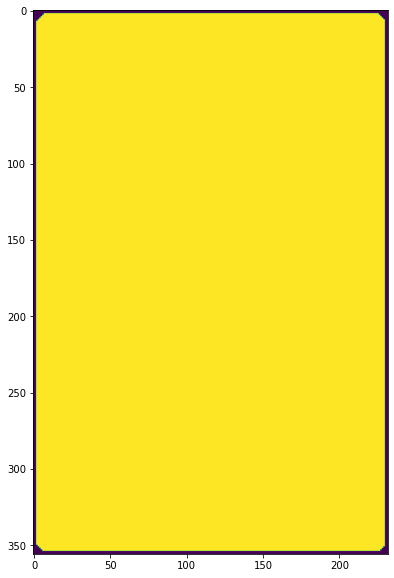

In [83]:
bord_size = 2  # bord_size alpha=0
alphamask = np.ones((cardH, cardW), dtype=np.uint8) * 255
cv2.rectangle(alphamask, (0, 0), (cardW - 1, cardH - 1), 0, bord_size)
cv2.line(alphamask, (bord_size * 3, 0), (0, bord_size * 3), 0, bord_size)
cv2.line(alphamask, (cardW - bord_size * 3, 0), (cardW, bord_size * 3), 0, bord_size)
cv2.line(alphamask, (0, cardH - bord_size * 3), (bord_size * 3, cardH), 0, bord_size)
cv2.line(
    alphamask,
    (cardW - bord_size * 3, cardH),
    (cardW, cardH - bord_size * 3),
    0,
    bord_size,
)
plt.figure(figsize=(10, 10))
plt.imshow(alphamask)


In [84]:
def varianceOfLaplacian(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()


def extract_card(img, output_fn=None, min_focus=120, debug=False):
    imgwarp = None

    # Check the image is not too blurry
    focus = varianceOfLaplacian(img)
    if focus < min_focus:
        if debug:
            print("Focus too low :", focus)
        return False, None

    # Convert in gray color
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Noise-reducing and edge-preserving filter
    gray = cv2.bilateralFilter(gray, 11, 17, 17)

    # Edge extraction
    edge = cv2.Canny(gray, 30, 200)

    # Find the contours in the edged image
    cnts, _ = cv2.findContours(
        edge.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
    )

    # We suppose that the contour with largest area corresponds to the contour delimiting the card
    cnt = sorted(cnts, key=cv2.contourArea, reverse=True)[0]

    # We want to check that 'cnt' is the contour of a rectangular shape
    # First, determine 'box', the minimum area bounding rectangle of 'cnt'
    # Then compare area of 'cnt' and area of 'box'
    # Both areas sould be very close
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    areaCnt = cv2.contourArea(cnt)
    areaBox = cv2.contourArea(box)
    valid = areaCnt / areaBox > 0.93 or True

    if valid:
        # We want transform the zone inside the contour into the reference rectangle of dimensions (cardW,cardH)
        ((xr, yr), (wr, hr), thetar) = rect
        # Determine 'Mp' the transformation that transforms 'box' into the reference rectangle
        if wr > hr:
            Mp = cv2.getPerspectiveTransform(np.float32(box), refCard)
        else:
            Mp = cv2.getPerspectiveTransform(np.float32(box), refCardRot)
        # Determine the warped image by applying the transformation to the image
        imgwarp = cv2.warpPerspective(img, Mp, (cardW, cardH))
        # Add alpha layer
        imgwarp = cv2.cvtColor(imgwarp, cv2.COLOR_BGR2BGRA)

        # Shape of 'cnt' is (n,1,2), type=int with n = number of points
        # We reshape into (1,n,2), type=float32, before feeding to perspectiveTransform
        cnta = cnt.reshape(1, -1, 2).astype(np.float32)
        # Apply the transformation 'Mp' to the contour
        cntwarp = cv2.perspectiveTransform(cnta, Mp)
        cntwarp = cntwarp.astype(int)

        # We build the alpha channel so that we have transparency on the
        # external border of the card
        # First, initialize alpha channel fully transparent
        alphachannel = np.zeros(imgwarp.shape[:2], dtype=np.uint8)
        # Then fill in the contour to make opaque this zone of the card
        cv2.drawContours(alphachannel, cntwarp, 0, 255, -1)

        # Apply the alphamask onto the alpha channel to clean it
        alphachannel = cv2.bitwise_and(alphachannel, alphamask)

        # Add the alphachannel to the warped image
        imgwarp[:, :, 3] = alphachannel

        # Save the image to file
        if output_fn is not None:
            cv2.imwrite(output_fn, imgwarp)
    else:
        print(areaCnt / areaBox)

    if debug:
        # cv2.namedWindow("Canny", cv2.WINDOW_NORMAL)
        cv2.imshow("Canny", edge)
        cv2.imshow("Gray", gray)
        edge_bgr = cv2.cvtColor(edge, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(edge_bgr, [box], 0, (0, 0, 255), 3)
        cv2.drawContours(edge_bgr, [cnt], 0, (0, 255, 0), -1)
        cv2.imshow("Contour with biggest area", edge_bgr)
        if valid:
            cv2.imshow("Alphachannel", alphachannel)
            cv2.imshow("Extracted card", imgwarp)

    return valid, imgwarp




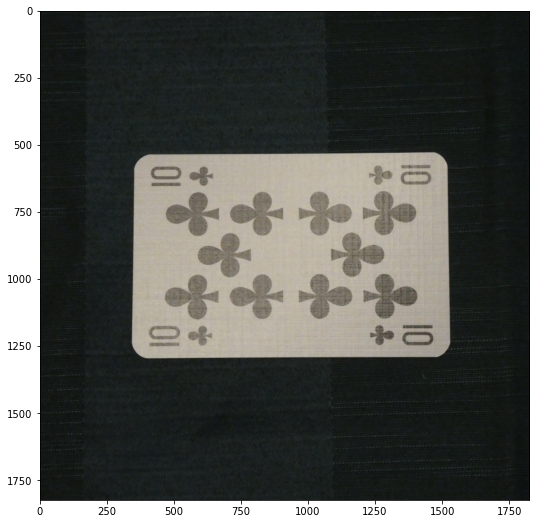

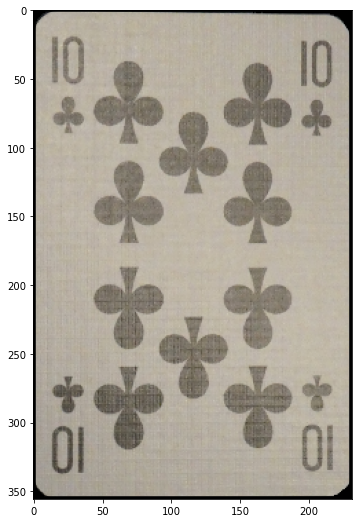

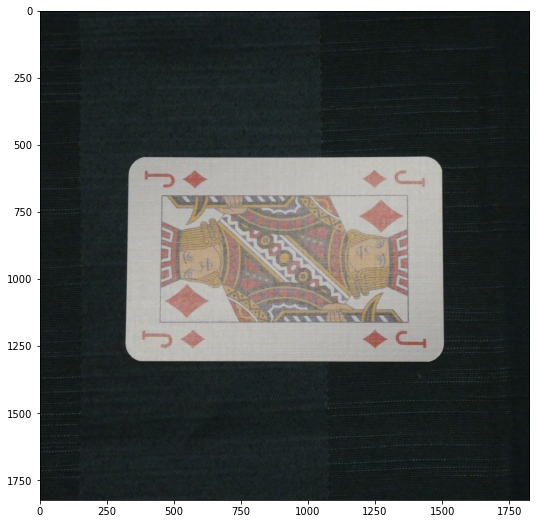

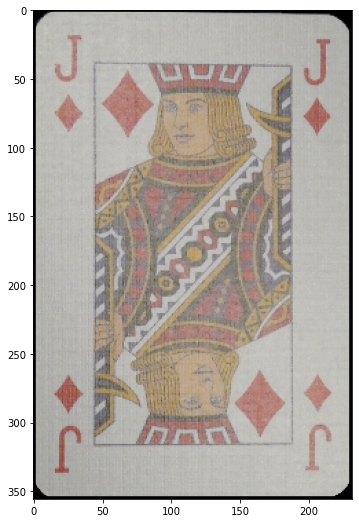

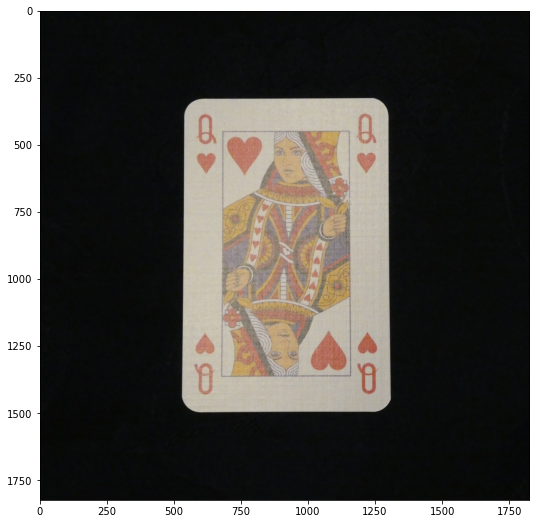

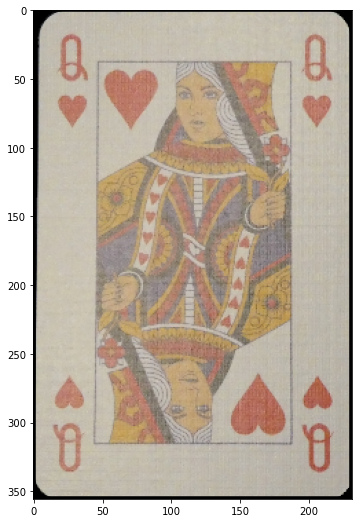

In [29]:
# Test on one image
sample = ["10C_12.jpg"]
debug = True
for ind, item in enumerate(sample):
    img = cv2.imread(DATA_DIR + IMAGES + ANGLE_1 + item)
    display_img(img)
    valid, card = extract_card(
        img, OUT_DIR + f"extracted.jpg", min_focus=30, debug=debug
    )
    if valid:
        display_img(card)
    else:
        print("Ciupaga")

    if debug:
        cv2.waitKey(0)
        cv2.destroyAllWindows()


In [30]:
!mkdir -p $OUT_DIR/angle_1

In [31]:
for angle in [ANGLE_1]:
    files = os.listdir(DATA_DIR + IMAGES + angle)
    files = [DATA_DIR + IMAGES + angle + f for f in files]
    for ind, f in enumerate(files):
        fname = f.split('/')[-1]
        img = cv2.imread(f)
        valid, card = extract_card(img, OUT_DIR + angle + fname, min_focus=26, debug=False)
        if not valid:
            print(f"Ciupaga dla {fname} w {angle}")


out/angle_1/9D_22.jpg


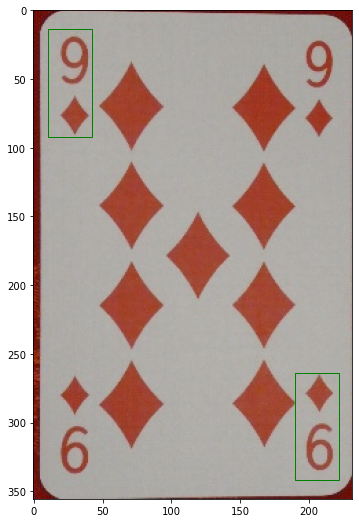

In [39]:
# Run a few times...
wrong = ["9C_22", "9S_22", "10S_22", "AD_22", "JC_22", "JH_21", "KD_21"]
wrong = [item + ".jpg" for item in wrong]

imgs_dir = OUT_DIR + ANGLE_1
imgs_fns = os.listdir(imgs_dir)
img_fn = OUT_DIR + ANGLE_1 + random.choice(imgs_fns)
print(img_fn)
display_img(
    cv2.imread(img_fn, cv2.IMREAD_UNCHANGED), polygons=[refCornerHL, refCornerLR]
)


In [140]:
def findHull(img, corner=refCornerHL, debug="no"):
    """
        Find in the zone 'corner' of image 'img' and return, the convex hull delimiting
        the value and suit symbols
        'corner' (shape (4,2)) is an array of 4 points delimiting a rectangular zone, 
        takes one of the 2 possible values : refCornerHL or refCornerLR
        debug=
    """

    kernel = np.ones((3, 3), np.uint8)
    corner = corner.astype(int)

    # We will focus on the zone of 'img' delimited by 'corner'
    x1 = int(corner[0][0])
    y1 = int(corner[0][1])
    x2 = int(corner[2][0])
    y2 = int(corner[2][1])
    w = x2 - x1
    h = y2 - y1
    zone = img[y1:y2, x1:x2].copy()

    strange_cnt = np.zeros_like(zone)
    gray = cv2.cvtColor(zone, cv2.COLOR_BGR2GRAY)
    thld = cv2.Canny(gray, 30, 200)
    thld = cv2.dilate(thld, kernel, iterations=1)
    if debug != "no":
        cv2.imshow("thld", thld)

    # Find the contours
    contours, _ = cv2.findContours(
        thld.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    min_area = 30  # We will reject contours with small area. TWEAK, 'zoom' dependant
    min_solidity = 0.3  # Reject contours with a low solidity. TWEAK

    concat_contour = (
        None  # We will aggregate in 'concat_contour' the contours that we want to keep
    )

    ok = True
    for c in contours:
        area = cv2.contourArea(c)

        hull = cv2.convexHull(c)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area
        # Determine the center of gravity (cx,cy) of the contour
        M = cv2.moments(c)
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        #  abs(w/2-cx)<w*0.3 and abs(h/2-cy)<h*0.4 : TWEAK, the idea here is to keep only the contours which are closed to the center of the zone
        if (
            area >= min_area
            and abs(w / 2 - cx) < w * 0.3
            and abs(h / 2 - cy) < h * 0.4
            and solidity > min_solidity
        ):
            if debug != "no":
                cv2.drawContours(zone, [c], 0, (255, 0, 0), -1)
            if concat_contour is None:
                concat_contour = c
            else:
                concat_contour = np.concatenate((concat_contour, c))
        if debug != "no" and solidity <= min_solidity:
            print("Solidity", solidity)
            cv2.drawContours(strange_cnt, [c], 0, 255, 2)
            cv2.imshow("Strange contours", strange_cnt)

    if concat_contour is not None:
        # At this point, we suppose that 'concat_contour' contains only the contours corresponding the value and suit symbols
        # We can now determine the hull
        hull = cv2.convexHull(concat_contour)
        hull_area = cv2.contourArea(hull)
        # If the area of the hull is to small or too big, there may be a problem
        min_hull_area = 940  # TWEAK, deck and 'zoom' dependant
        max_hull_area = 2120  # TWEAK, deck and 'zoom' dependant
        if hull_area < min_hull_area or hull_area > max_hull_area:
            ok = False
            if debug != "no":
                print("Hull area=", hull_area, "too large or too small")
        # So far, the coordinates of the hull are relative to 'zone'
        # We need the coordinates relative to the image -> 'hull_in_img'
        hull_in_img = hull + corner[0]

    else:
        ok = False

    if debug != "no":
        if concat_contour is not None:
            cv2.drawContours(zone, [hull], 0, (0, 255, 0), 1)
            cv2.drawContours(img, [hull_in_img], 0, (0, 255, 0), 1)
        cv2.imshow("Zone", zone)
        cv2.imshow("Image", img)
        if ok and debug != "pause_always":
            key = cv2.waitKey(1)
        else:
            key = cv2.waitKey(0)
        if key == 27:
            return None
    if ok == False:

        return None

    return hull_in_img


out/angle_1/AH_01.jpg


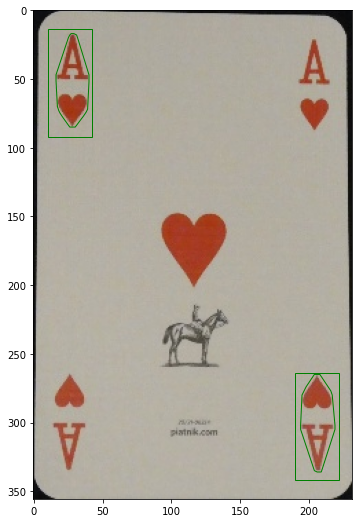

In [142]:
# Test find_hull on a random card image
# debug = "no" or "pause_always" or "pause_on_pb"
# If debug!="no", you may have to press a key to continue execution after pause
debug = "no"

imgs_dir = OUT_DIR + ANGLE_1
imgs_fns = os.listdir(imgs_dir)
img_fn = OUT_DIR + ANGLE_1 + random.choice(imgs_fns)
print(img_fn)

img = cv2.imread(img_fn, cv2.IMREAD_UNCHANGED)
hullHL = findHull(img, refCornerHL, debug=debug)
hullLR = findHull(img, refCornerLR, debug=debug)

display_img(img, [refCornerHL, refCornerLR, hullHL, hullLR])

if debug != "no":
    cv2.destroyAllWindows()
